# Stack Overflow Tags Prediction with OneVsRest Classifier

*These codes were referred from [this GitHub Repository](https://github.com/prabhnoor0212/StackOverflow-Tag-Prediction)*

This taks to predict tags for a StackOverflow dataset.
Given Questions and Body, we need to predict the tags for each Questions presented.

This notebook is run on Google Colaboratory.



## Import necessary libraries and get the data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

import collections

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import seaborn as sns
from datetime import datetime

from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Get the data from Google Drive**

In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Get the data**

*From the 7GB of data, due to the low computing resources, I just take 20% of the data for this prediction project*

In [0]:
!ls "../content/drive/My Drive/ColabNotebooks/StackoverflowTagsPrediction"

'Load data.ipynb'   StackOverFlow_LSTM.ipynb
 new_train_2.zip    Stack_Overflow_Tags_Prediction.ipynb
 new_train.zip


In [0]:
#unzip the data
!unzip "../content/drive/My Drive/ColabNotebooks/StackoverflowTagsPrediction/new_train_2.zip" -d train

Archive:  ../content/drive/My Drive/ColabNotebooks/StackoverflowTagsPrediction/new_train_2.zip
replace train/new_train_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/new_train_2.csv   


In [0]:
!ls

data2.csv  data.csv  drive  sample_data  tag.png  train


In [0]:
#read the data
data = pd.read_csv("../content/train/new_train_2.csv")

## Data Analysis

In [0]:
data.describe()

,Unnamed: 0,Id
count,1.206839e+06,1.206839e+06
mean,3.015173e+06,3.015174e+06
std,1.742191e+06,1.742191e+06
min,0.000000e+00,1.000000e+00
25%,1.506072e+06,1.506072e+06
50%,3.014975e+06,3.014976e+06
75%,4.523268e+06,4.523269e+06
max,6.034193e+06,6.034194e+06


In [0]:
data.head()

,Unnamed: 0,Id,Title,Body,Tags
0,1152437,1152438,javascript - How to make this code work?,<p>Code gives me:\nA\nB\nC</p>\n\n<p>When I cl...,javascript jquery closures
1,585587,585588,How to insert a banner image in a random listv...,<p>How can I insert a banner image in a listvi...,asp.net listview data rows banner
2,4422106,4422107,ScatterViewItem.Center (X and Y) properties re...,<p>I have a XAML based <code>ScatterView</code...,c# wpf wpf-controls pixelsense scatterview
3,6005780,6005781,Is it possible to stream to an Android phone w...,<p>Let's say that I have Microsoft Media Serve...,android microsoft stream multimedia
4,4851238,4851239,Windows server 2008 R2 backup - clear stale re...,<p>I have been using Windows Server 2008 R2 ba...,windows-server-2008-r2 backup


In [0]:
data.shape

(1206839, 5)

In [0]:
data.tail(10)

,Unnamed: 0,Id,Title,Body,Tags
1206829,3265326,3265327,locale based sorting function in ruby,<p>For my application(Ruby on Rails) i have co...,ruby-on-rails ruby internationalization
1206830,2854650,2854651,How to upload a file in Tomcat5.5?,<p>I want to do the following in tomcat 5.5</p...,java tomcat5.5
1206831,587290,587291,Setting up svn manually for the first time - P...,"<p>Following various tutorials, I've got svn r...",linux apache2 permissions svn
1206832,2119626,2119627,Clean separation of UI with Caliburn MVVM,<p>Looking into various MVVM frameworks for SL...,mvvm caliburn
1206833,5650143,5650144,Security essentials error code: 0x80501001,"<p>Using Microsoft Security Essentials, I am g...",ms-security-essentials
1206834,5734533,5734534,Error while trying to use gwt-cal and gwt-dnd,<p>I have a simple GWT project and I was tryin...,gwt
1206835,4879478,4879479,Eager loading in Rails 3?,<p>I am attempting to learn how to increase th...,mysql ruby-on-rails-3 eager-loading bullet
1206836,1829365,1829366,Silex Setting Middleware to a ControllerCollec...,<p>I want to do something like this:</p>\n\n<p...,middleware silex
1206837,495667,495668,Examples of program that writes programs,<p>Where can I find such programs? I think yac...,java c perl
1206838,4129950,4129951,Must haves for web hosting service to learn or...,<p>I'm new to web administration but would lik...,webserver hosting web-hosting tools


In [0]:
#drop the unnecessary column
data= data.drop(columns=["Unnamed: 0"])

In [0]:
data.head()

,Id,Title,Body,Tags
0,1152438,javascript - How to make this code work?,<p>Code gives me:\nA\nB\nC</p>\n\n<p>When I cl...,javascript jquery closures
1,585588,How to insert a banner image in a random listv...,<p>How can I insert a banner image in a listvi...,asp.net listview data rows banner
2,4422107,ScatterViewItem.Center (X and Y) properties re...,<p>I have a XAML based <code>ScatterView</code...,c# wpf wpf-controls pixelsense scatterview
3,6005781,Is it possible to stream to an Android phone w...,<p>Let's say that I have Microsoft Media Serve...,android microsoft stream multimedia
4,4851239,Windows server 2008 R2 backup - clear stale re...,<p>I have been using Windows Server 2008 R2 ba...,windows-server-2008-r2 backup


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206839 entries, 0 to 1206838
Data columns (total 4 columns):
Id       1206839 non-null int64
Title    1206839 non-null object
Body     1206839 non-null object
Tags     1206837 non-null object
dtypes: int64(1), object(3)
memory usage: 36.8+ MB


In [0]:
#checking for duplicates and drop the duplicates

data = data.drop_duplicates(subset={'Id', 'Title', 'Body', 'Tags'})

## Tags analysis

### Calculate the total number of unique tags

In [0]:
data.dropna(inplace=True)

In [0]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(data['Tags'])

In [0]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 1206837
Number of unique tags : 36018


In [0]:
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.ds-store', '.each']


### Calculate the number of times a tag appeared

In [0]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

tag_dtm.sum(axis=0)

matrix([[5, 9, 1, ..., 6, 8, 1]], dtype=int64)

In [0]:
tag_dtm.shape

(1206837, 36018)

In [0]:
freqs.shape

(36018,)

In [0]:
tag_df = pd.DataFrame()
tag_df['Tags'] = result.keys()
tag_df['Counts'] = result.values()
tag_df.head()

,Tags,Counts
0,.a,5
1,.app,9
2,.asp.net-mvc,1
3,.aspxauth,7
4,.bash-profile,39


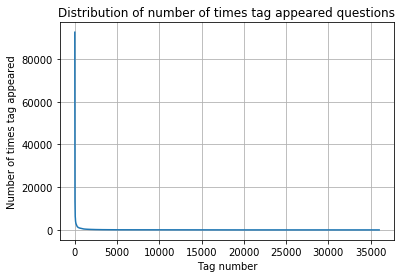

In [0]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

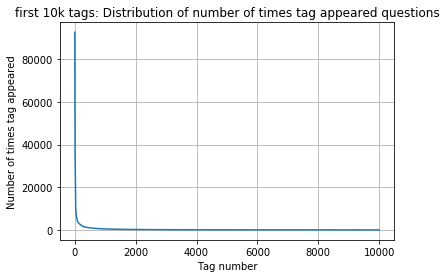

400 [92548 12524  6408  5147  3784  3198  2857  2612  2268  2130  1874  1690
  1532  1449  1332  1236  1184  1129  1087  1030   988   945   912   867
   832   793   764   735   705   677   659   641   610   593   570   550
   521   503   488   480   462   449   439   429   420   411   402   393
   385   378   372   363   349   342   335   329   324   316   312   306
   300   296   291   287   282   275   272   268   264   260   257   252
   248   244   240   236   233   229   226   222   218   216   213   209
   205   201   198   196   194   191   188   186   183   181   179   176
   174   171   169   166   164   162   159   158   155   153   151   149
   147   146   144   142   141   140   138   137   136   134   132   130
   129   127   126   124   123   122   121   120   118   117   115   114
   113   112   111   110   109   108   107   106   105   104   102   102
   101   100    99    98    97    96    95    94    93    92    91    91
    90    89    88    87    87    86    85    8

In [0]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

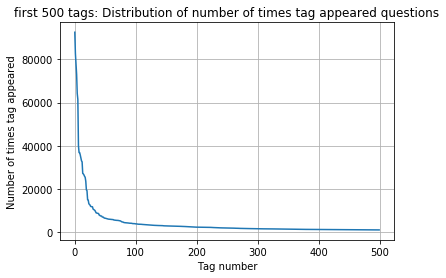

100 [92548 61406 34201 26467 19158 12524 10643  8873  7850  6954  6408  5994
  5903  5534  5412  5147  4452  4284  4098  3920  3784  3638  3544  3434
  3305  3198  3112  3089  3001  2903  2857  2804  2763  2714  2671  2612
  2556  2485  2414  2329  2268  2229  2215  2186  2164  2130  2044  2004
  1924  1888  1874  1839  1802  1762  1697  1690  1625  1605  1573  1553
  1532  1504  1492  1476  1468  1449  1426  1397  1369  1361  1332  1322
  1288  1262  1252  1236  1228  1213  1203  1192  1184  1173  1162  1155
  1141  1129  1120  1113  1104  1094  1087  1073  1053  1042  1033  1030
  1025  1007  1003   998]


In [0]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

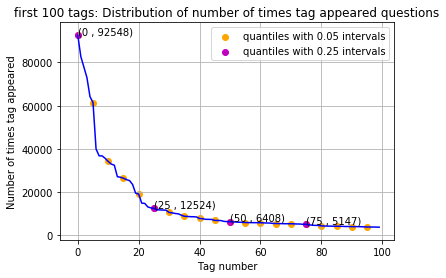

20 [92548 61406 34201 26467 19158 12524 10643  8873  7850  6954  6408  5994
  5903  5534  5412  5147  4452  4284  4098  3920]


In [0]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [0]:
#tags greater than 1K
lst_tags_gt_1k = tag_df[tag_df.Counts>1000].Tags
print ('{} Tags are used more than 1000 times'.format(len(lst_tags_gt_1k)))
#tags greater than 10K
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
#tags greater than 100K
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

494 Tags are used more than 1000 times
34 Tags are used more than 10000 times
0 Tags are used more than 100000 times


**Observationns**:

1.   494 tags are used more than 1000 times
2.   34 tags are use more than 10000 times
3.   Most frequent tag used in 46252 times.
4.   Since some tags occur more frequent than others, micro-averaged F1-score is the appropriate metric for this problem. 



### Calculate the number of tags per question

In [0]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 1206837 datapoints.
[3, 5, 5, 4, 2]


In [0]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.884656


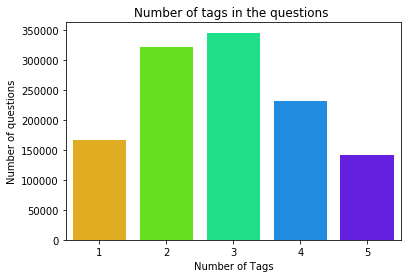

In [0]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

### Most Frequent Tags

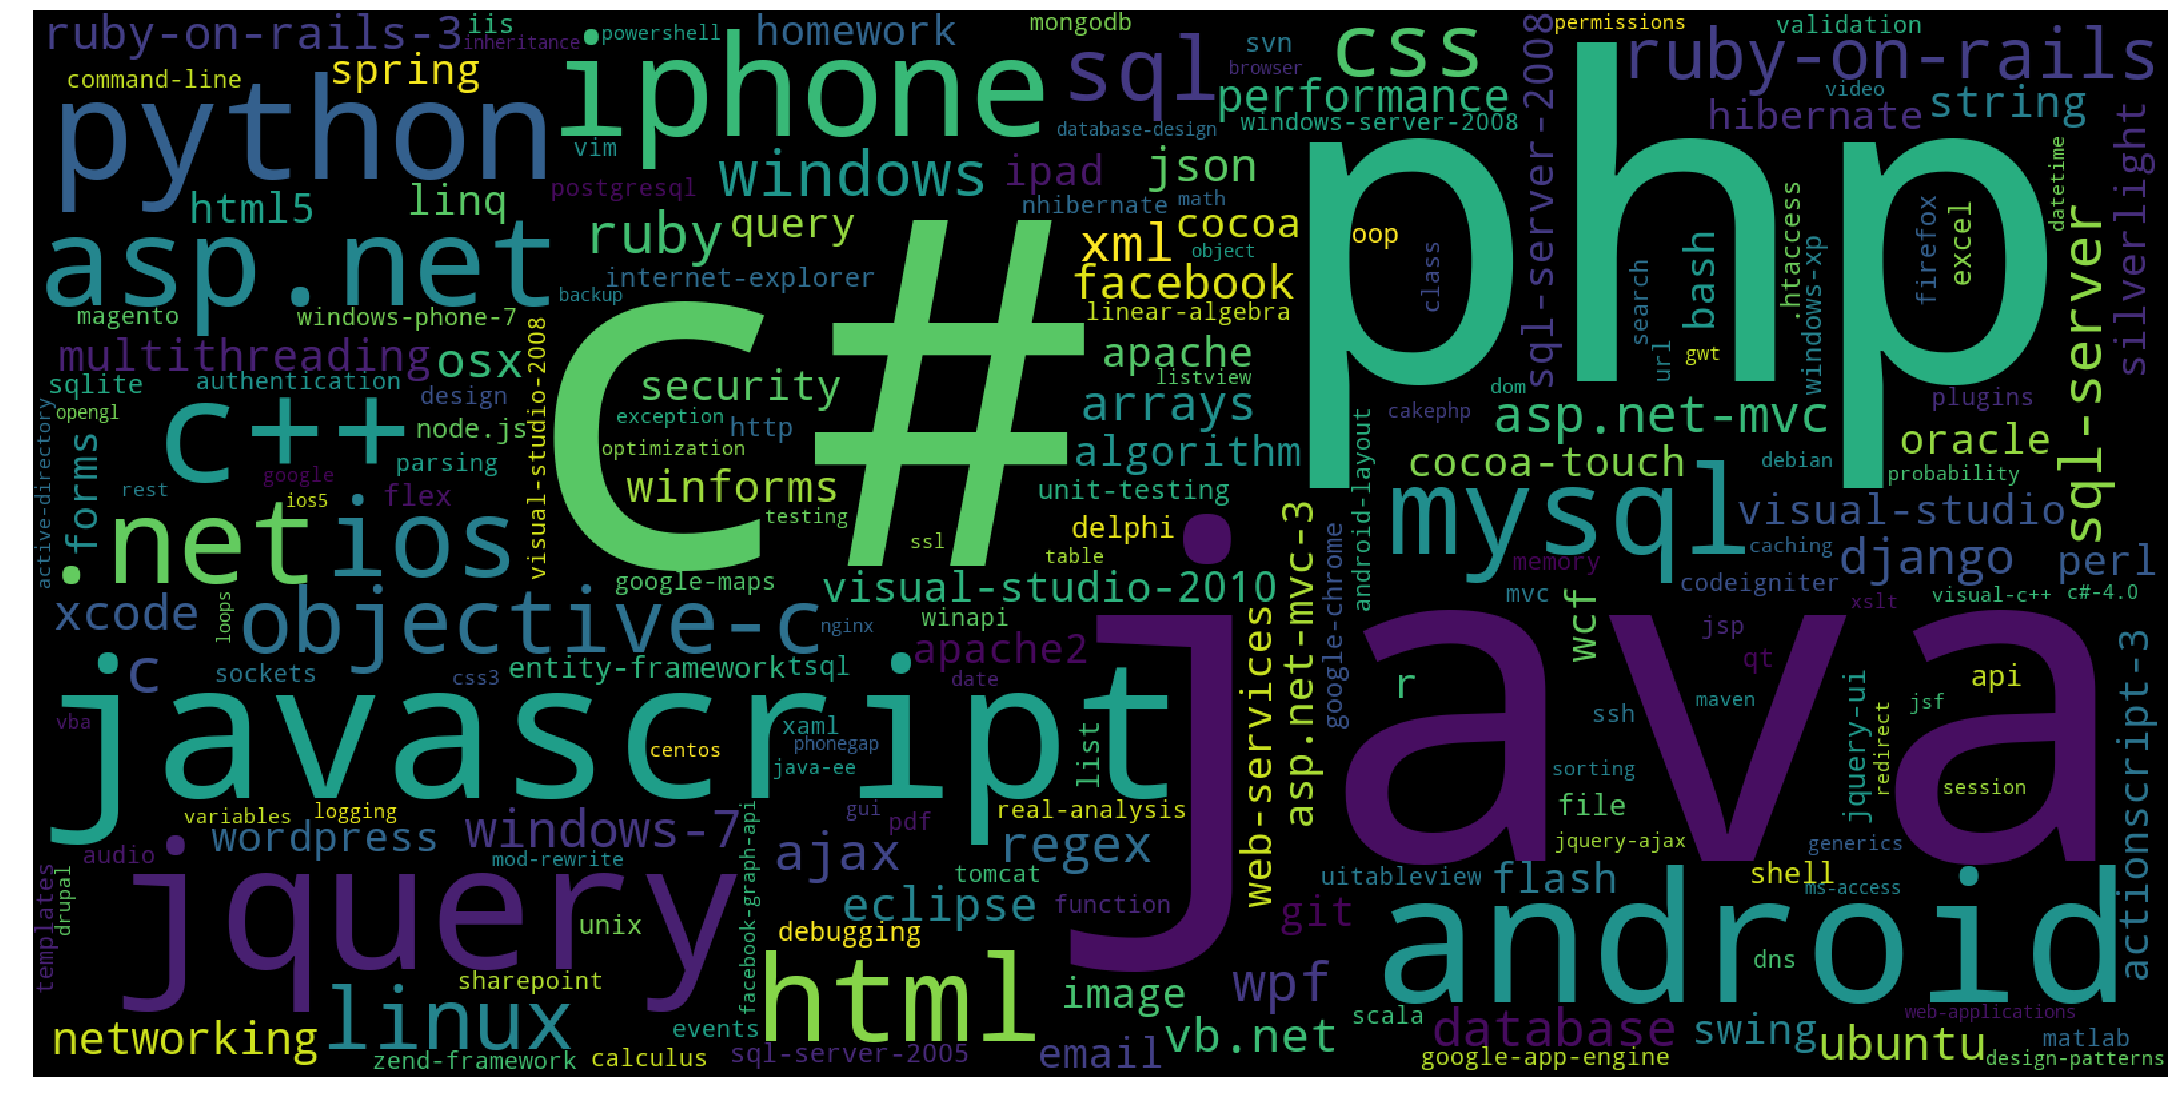

In [0]:
# Ploting word cloud
start = datetime.now()


#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(result)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

### The Top 30 tags

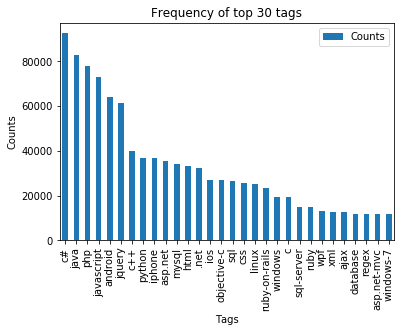

In [0]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

### Cleaning and Preprocessing the Questions

#### Preprocessing
1. Sample 0.5M data points

2. Separate out code-snippets from Body

3. Remove Spcial characters from Question title and description (not in code)

4. Remove stop words (Except 'C')

5. Remove HTML Tags

6. Convert all the characters into small letters

7. Use SnowballStemmer to stem the words



In [0]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
def stripcode(data):
    # flags= re.DOTALL matches \n also
    return re.sub('<code>(.*?)</code>', '', str(data), flags=re.MULTILINE|re.DOTALL),str(re.findall(r'<code>(.*?)</code>', str(data), flags=re.DOTALL))
def stripunc(data):
    return re.sub('[^A-Za-z]+', ' ', str(data), flags=re.MULTILINE|re.DOTALL)
    
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [0]:
sampled_data = data.sample(frac=0.2, random_state=1)
sampled_data.shape

(241367, 4)

In [0]:
sampled_data.reset_index(drop=True, inplace=True)

In [0]:
str(re.findall(r'<code>(.*?)</code>', sampled_data['Body'][16], flags=re.DOTALL))

'[\'addSbtPlugin("com.typesafe.sbt" % "sbt-aspectj" % "0.9.0")\\n\', \'import sbt._\\nimport Keys._\\nimport play.Project._\\nimport com.typesafe.sbt.SbtAspectj._\\nimport com.typesafe.sbt.SbtAspectj.AspectjKeys._\\n\\nobject ApplicationBuild extends Build {\\n\\n    val appDependencies = Seq(javaCore)\\n\\n    val main = play.Project(appName, appVersion, appDependencies).settings(\\n        AspectjKeys.verbose in Aspectj := true,\\n        AspectjKeys.showWeaveInfo in Aspectj := true,\\n        AspectjKeys.inputs in Aspectj &lt;+= compiledClasses\\n    )\\n\\n}\\n\', \'[error] Reference to undefined setting: \\n[error] \\n[error]   aspectj:inputs from aspectj:inputs\\n\']'

In [0]:
str(re.findall(r'[^A-Za-z]+', sampled_data['Body'][11], flags=re.DOTALL))

'[\'<\', \'>\', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \'?</\', \'>\\n\\n<\', \'>\', \' \', \' \', \' \', \' \', \' \', \' \', \', \', \' \', \' \', \' \', \' \', "\'", \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \'?</\', \'>\\n\\n<\', \'>\', \' \', \', $\\\\\', \'{1}{1-\', \'}$ \', \' \', \' \', \' $\\\\\', \'_{\', \'=0}^\\\\\', \'{\', \'^\', \'}$.  \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \'.</\', \'>\\n\\n<\', \'>\', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \'.  \', "\'", \' \', \' \', \' \', \' \', \', \', \' \', \' \', \' \', \' \', \' \', \' \', \'.  \', \', \', "\'", \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \'.</\', \'>\\n\\n<\', \'>\', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \'?</\', \'>\\n\\n<\', \'>\', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \' \', \', \', \'. \', \' \', 

In [0]:
sampled_data.columns

Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')

In [0]:
def compute(qtup):
    tid = qtup[0]
    ttitle = qtup[1]
    tbody = qtup[2]
    ttags = qtup[3]
    
    tbody,code = stripcode(tbody)
    #ttitle=ttitle.encode('utf-8')
    tbody = str(ttitle)+" "+str(tbody)
    tbody = stripunc(tbody)
    words=word_tokenize(str(tbody.lower()))
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    tbody=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    return pd.Series([tid,tbody,ttags,code])

In [0]:
results = sampled_data[['Id','Title','Body','Tags']].apply(compute,axis=1)
results.columns =['Id', 'Question', 'Tags', 'Code']
results.head(20)

,Id,Question,Tags,Code
0,3699217,voic speech text need api librari prefer free ...,c# .net speech-recognition voice-recognition s...,[]
1,1078454,avoid time sychron osx xp use parallel need xp...,osx sync time parallels,[]
2,3491061,gridview add multipl command one item templat ...,c# asp.net gridview templatefield rowcommand,"[' &lt;asp:GridView ID=""GridView1"" runa..."
3,463212,recur event hi read lot recur topic still zero...,php mysql,['id | title | start | end ...
4,142518,resourc write compil backend oo languag greet ...,c compiler resources backend,[]
5,3858191,codeignit datamapp add tablenam construct cms ...,codeigniter codeigniter-datamapper,"[""class Module_universeel extends DataMapper {..."
6,2017817,unabl connect mysql databas use tomcat ubuntu ...,mysql database ubuntu tomcat6,['javax.servlet.ServletException: Could not co...
7,4584638,continu c impli limit c true href http math st...,homework real-analysis limit functions continuity,[]
8,4334163,what differ construct init wonder differ funct...,php zend-framework,"['__construct()', 'init()']"
9,2844941,get arg kprobe find reg rdi write kernel modul...,linux kernel kprobe,"['regs-&gt;rdi', 'error: ‘struct pt_regs’ has ..."


In [0]:
results.to_csv('data.csv',index=False)
results.shape

(241367, 4)

In [0]:
final_data = pd.read_csv('data.csv')
final_data.shape

(241367, 4)

In [0]:
print("Questions after pre-processing:")
for a in final_data['Question'].head(10):
    print(a)
    print("*"*100)

Questions after pre-processing:
voic speech text need api librari prefer free convert voic speech microphon text string addit need api librari text speech like use c net languag suffic thank
****************************************************************************************************
avoid time sychron osx xp use parallel need xp virtual machin system date de synchron osx host server use parall figur option alreadi uncheck synchron time server insid xp box thank
****************************************************************************************************
gridview add multipl command one item templat strip exampl make simpl gridview templat field templat field contain two button label must templat field want first button set label text win button set label text fail onrowcommand doesnt seem trigger button templat field accomplish gridview code pre pre code behind pre pre thank advanc
******************************************************************************************

In [0]:
count = 0
for c in final_data['Code']:
    if c=='[]':
        count += 1

In [0]:
print("Percentage of questions containing code : %f"% np.round(((final_data.shape[0] - count) / final_data.shape[0]) * 100, 3))

Percentage of questions containing code : 56.209000


In [0]:
processed_data = final_data[['Question','Tags']]

In [0]:
processed_data.head()

,Question,Tags
0,voic speech text need api librari prefer free ...,c# .net speech-recognition voice-recognition s...
1,avoid time sychron osx xp use parallel need xp...,osx sync time parallels
2,gridview add multipl command one item templat ...,c# asp.net gridview templatefield rowcommand
3,recur event hi read lot recur topic still zero...,php mysql
4,resourc write compil backend oo languag greet ...,c compiler resources backend


## Building the Machine Learning Models

### Converting tags for multilabel problems

In [0]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(processed_data['Tags'])

In [0]:
#sample the number of tags due to limitation of computing power
len(multilabel_y.sum(axis=0).tolist()[0])

24942

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=processed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

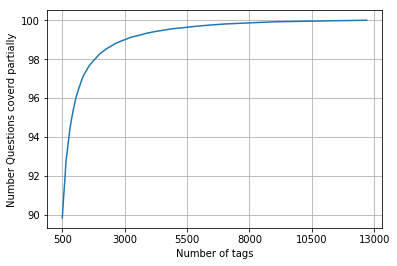

with  5500 tags we are covering  98.998 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [0]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 2418 out of  241367


In [0]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 24942
number of tags taken : 5500 ( 22.051158688156523 %)


### Split the data into train, valid and test (4:1)

Using SKLearn train_test_split

In [0]:
x_train, x_test, y_train, y_test =train_test_split(processed_data, multilabel_yx, test_size=0.20, shuffle=True)

In [0]:
print(x_train.shape)
print(x_test.shape)

(193093, 2)
(48274, 2)


### Featurizing the data

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['Question'])
x_test_multilabel = vectorizer.transform(x_test['Question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:44.617278


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (193093, 98604) Y : (193093, 5500)
Dimensions of test data X: (48274, 98604) Y: (48274, 5500)


### Applying logistic regression with OneVsRest classifier

OvR multiclass/multilabel strategy also known as one-vs-all. This strategy consists in fitting one classifier per class. For each classifier, the class is fitted againts all the other classes. This strategy can also be used for multilabel learning, where a classifier is used to predict multiple labels for instance, by fitting on a 2-d matrix in which cell [i, j] is 1 if sample i has label j and 0 otherwise.

This task required multilable classification where each label represents a different classification task, but the tasks are somehow related.

In [0]:
def compute2(qtup):
    tid = qtup[0]
    ttitle = qtup[1]
    tbody = qtup[2]
    ttags = qtup[3]
    
    tbody,code = stripcode(tbody)
    #ttitle=ttitle.encode('utf-8')
    tbody = str(ttitle)+" "+str(ttitle)+" "+str(ttitle)+" "+str(tbody)
    tbody = stripunc(tbody)
    words=word_tokenize(str(tbody.lower()))
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    tbody=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    return pd.Series([tid,tbody,ttags,code])

In [0]:
results2 = sampled_data[['Id','Title','Body','Tags']].apply(compute2,axis=1)

In [0]:
results2.head().iloc[0,1]

'voic speech text voic speech text voic speech text need api librari prefer free convert voic speech microphon text string addit need api librari text speech like use c net languag suffic thank'

In [0]:
results2.columns = ['id','question','tags','code']

In [0]:
results2.to_csv("data2.csv",index=False)

In [0]:
preprocessed_data = pd.read_csv("data2.csv")

In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 241367
number of dimensions : 4


**Use the `CountVectorizer` to convert `Tags` into multilable output**

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

**Choose 500 Tags only**

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

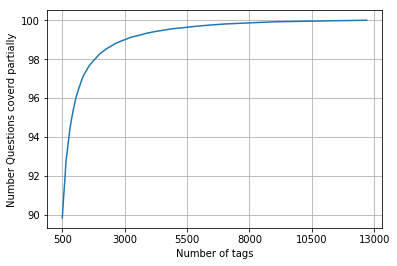

with  5500 tags we are covering  98.998 % of questions
with  500 tags we are covering  89.847 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
# we will be taking 500 tags as the labels and data
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 24505 out of  241367


In [0]:
x_train, x_test, y_train, y_test =train_test_split(preprocessed_data, multilabel_yx, test_size=0.2, shuffle=True)

In [0]:
print(x_train.shape)
print(x_test.shape)

(193093, 4)
(48274, 4)


**Featurizing data with Tf-Idf vectorizer**

Tf-IDF is a short term for term-frequency-inverse document frequency. It is a numerical statistic that is intended to relflect how important a word is to a document in a collection or corpus. 

Refer to [this website](http://www.tfidf.com/) for more info.

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:51.491702


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (193093, 100304) Y : (193093, 500)
Dimensions of test data X: (48274, 100304) Y: (48274, 500)


### Apply logistic regression with OneVsRest Classifier

**Performance metric**

Micro-Averaged F1-Score (Mean F Score) : The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

$F1 = 2 \times \frac{precision \times recall} { precision + recall}$

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

*Micro f1 score*:

Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.

*Macro f1 score*:

Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

More info of the implementation is in [this SKlearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

*Hamming loss* : 

The Hamming loss is the fraction of labels that are incorrectly predicted as referred to [this SKlearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html).



In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23521978704892904
Hamming loss  0.0027892447280109377
Micro-average quality numbers
Precision: 0.7227, Recall: 0.3506, F1-measure: 0.4722
Macro-average quality numbers
Precision: 0.5455, Recall: 0.2691, F1-measure: 0.3437
              precision    recall  f1-score   support

           0       0.63      0.26      0.37      3806
           1       0.81      0.45      0.58      3326
           2       0.83      0.54      0.65      3032
           3       0.78      0.45      0.57      2942
           4       0.95      0.75      0.84      2555
           5       0.88      0.65      0.75      2423
           6       0.72      0.33      0.45      1575
           7       0.89      0.60      0.71      1440
           8       0.73      0.41      0.53      1439
           9       0.80      0.42      0.55      1479
          10       0.88      0.62      0.73      1328
          11       0.54      0.19      0.28      1310
          12       0.58      0.14      0.22      1300
        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklea

## Summary

Data used is 20% from overall data, then it is sampled for another 20% due to the limited computing capability to process all data.

Tags used for partial coverage is 500.

Data is divided into train and test data set with ratio `4:1`.

Model used to calculate the F1-score is TF-IDF and logistic regression with OneVsRestClassifier. 

Accuracy : 0.23521978704892904

Hamming loss  0.0027892447280109377

Micro-average quality numbers

Precision: 0.7227, Recall: 0.3506, F1-measure: 0.4722
Macro-average quality numbers

Precision: 0.5455, Recall: 0.2691, F1-measure: 0.3437

